In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot

In [2]:
def length_to_windows(length_df, pops, window_size=100000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen200/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

In [11]:
meta_data_abr = meta_data_samples.loc[:, ~meta_data_samples.columns.isin(['longitude', 'latitude',
                                                                          'callset_index'])]
meta_data_abr.to_csv("../data/Papio_metadata.txt", index=False, sep=",")

In [12]:
meta_data_abr

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,C_origin
0,Sci_16066,16066_3130,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania","Cynocephalus, Central Tanzania"
1,Sci_16098,16098_5026,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania","Cynocephalus, Central Tanzania"
2,Sci_30877,30877_3426,James Else,Papio,anubis,"Aberdare, Kenya",M,"Aberdare National Park, Nyeri, Central Kenya, ...","Anubis, Kenya"
3,Sci_30977,30977_3373,James Else,Papio,anubis,"Aberdare, Kenya",F,"Aberdare National Park, Nyeri, Central Kenya, ...","Anubis, Kenya"
4,Sci_34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia","Kindae, Zambia"
...,...,...,...,...,...,...,...,...,...
222,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia","Kindae, Zambia"
223,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia","Kindae, Zambia"
224,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia","Kindae, Zambia"
225,PD_0793,34422_BZ11070,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",M,"Chunga, Mumbwa District, Central Province, Zambia","Kindae, Zambia"


In [4]:
pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

In [5]:
north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Kindae, Zambia': -1,
 'Papio, Senegal': 1,
 'Ursinus, Zambia': -1}

In [6]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(10, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [7]:
mean_hap_df = length_df.groupby(["individual", "chrom", "pos", "length"])[["n/s"]].mean().reset_index()
mean_hap_df = mean_hap_df.rename(columns={"pos": "start"})
mean_hap_df["windows"] = mean_hap_df.start
mean_hap_df["north"] = mean_hap_df["n/s"]

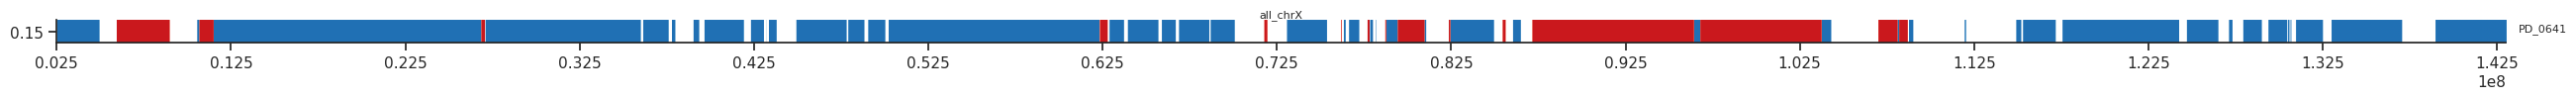

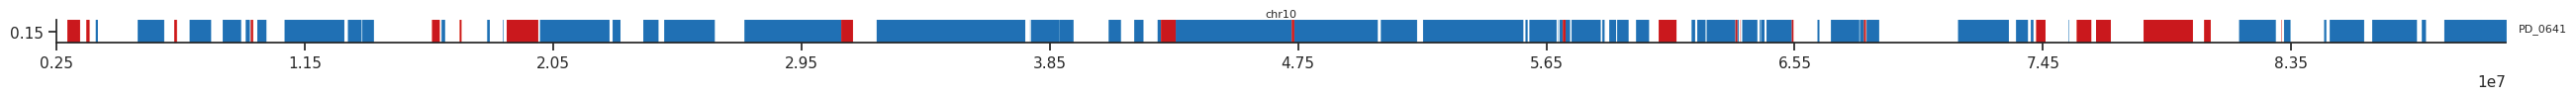

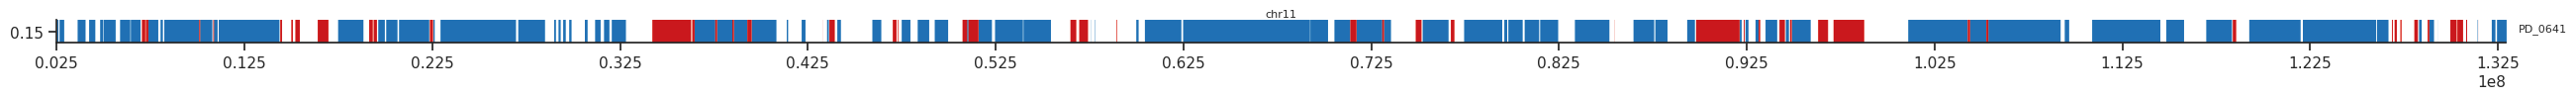

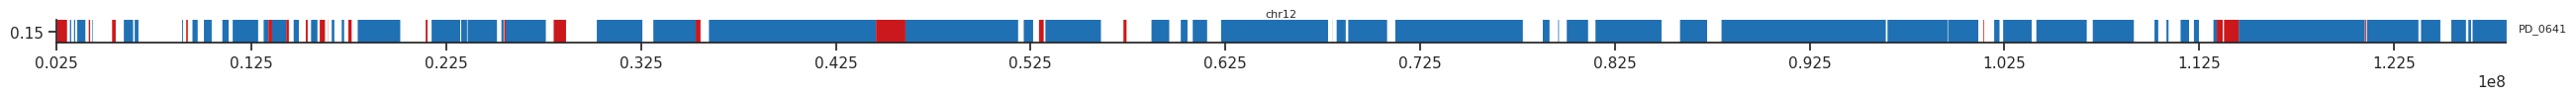

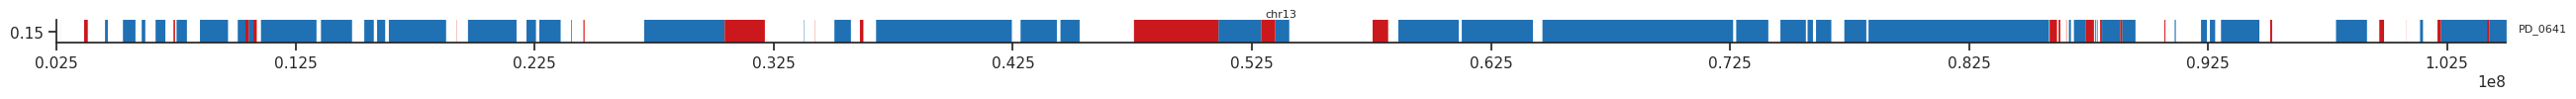

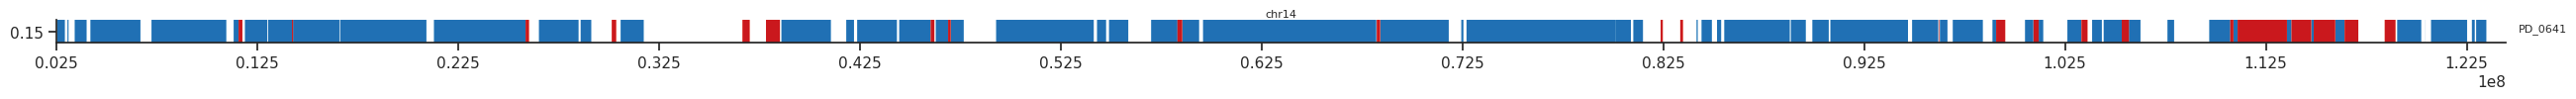

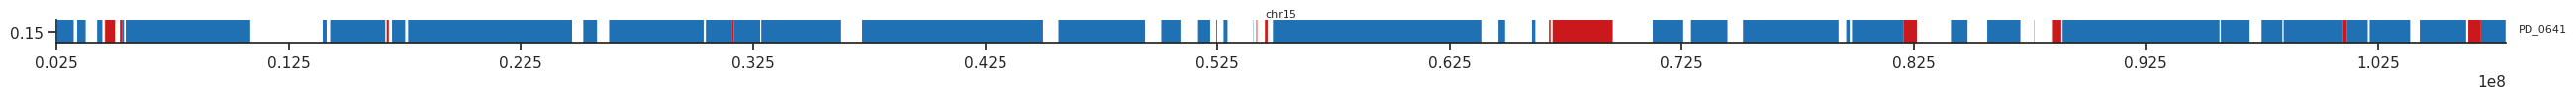

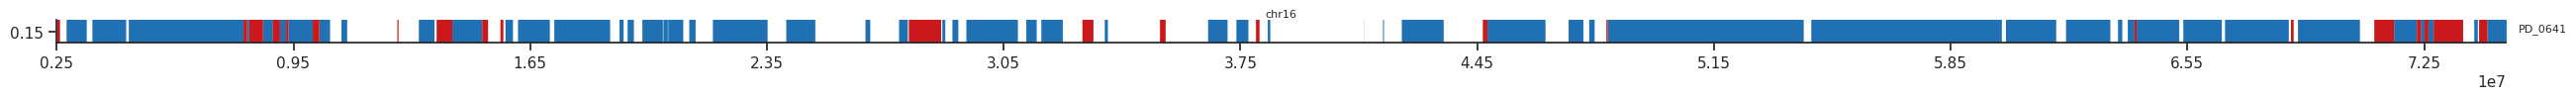

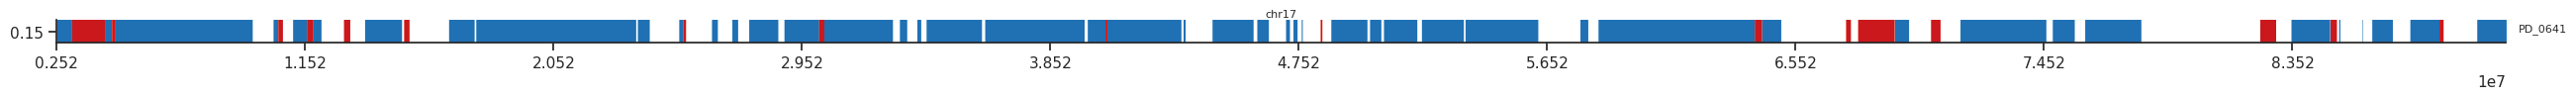

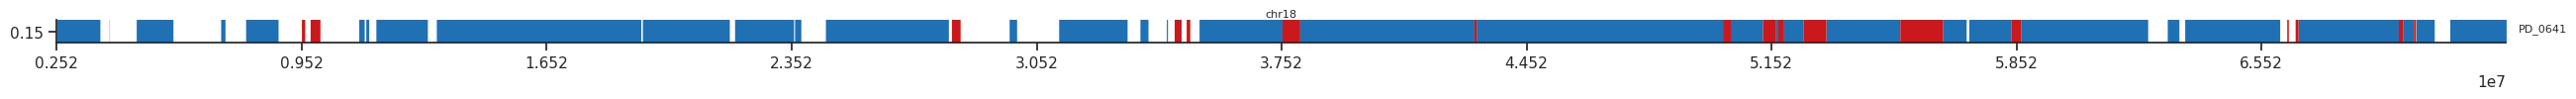

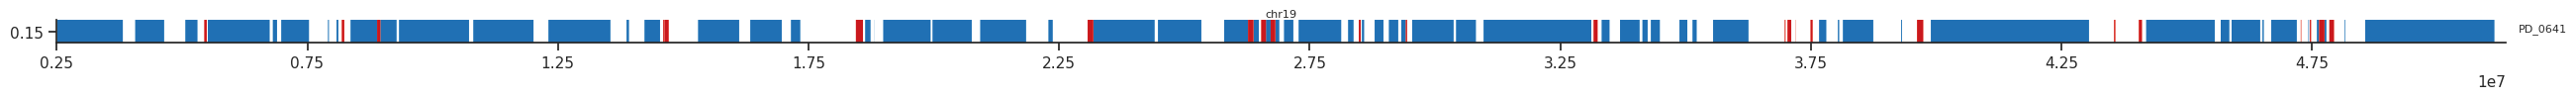

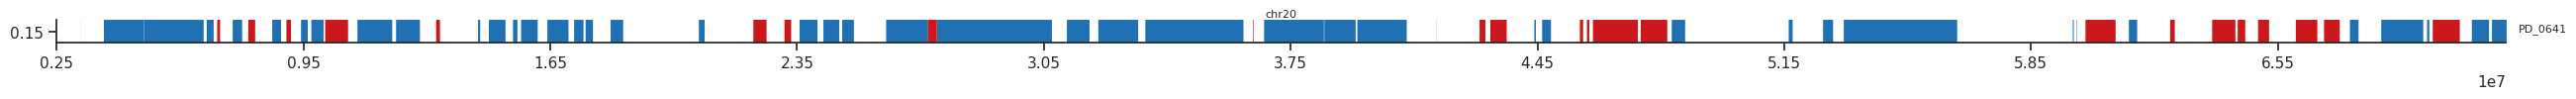

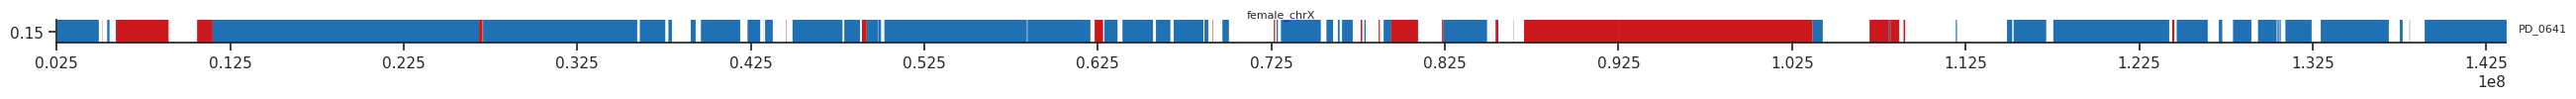

In [8]:
ind_test = mean_hap_df.loc[mean_hap_df.individual == "PD_0641"]
for c in ind_test.chrom.unique():
    c_sub = ind_test.loc[(ind_test.chrom == c) & (ind_test.windows >= 2500000)]
    fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [9]:
x_df = mean_hap_df.loc[mean_hap_df.chrom.isin(["all_chrX"])]
autosomal_df = mean_hap_df.loc[~mean_hap_df.chrom.isin(["all_chrX", "female_chrX"])]

In [10]:
x_df["fragment_weight_x"] = x_df["n/s"]*x_df["length"]

/scratch/22195603/ipykernel_1504096/1567058277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df["fragment_weight_x"] = x_df["n/s"]*x_df["length"]


In [11]:
x_length = x_df.loc[x_df.individual == "PD_0199"].length.sum()

In [12]:
percentage_north_x = ((x_df.groupby(by=["individual"])[["fragment_weight_x"]].sum()+x_length)/(2*x_length))

In [13]:
percentage_north_x.sort_values(by="fragment_weight_x", ascending=False)

,fragment_weight_x
individual,
PD_0733,0.999583
PD_0740,0.999154
PD_0723,0.999154
PD_0737,0.999110
PD_0734,0.999066
...,...
PD_0237,0.023954
PD_0225,0.023946
PD_0235,0.022913


In [14]:
autosomal_df["fragment_weight_aut"] = autosomal_df["n/s"]*autosomal_df["length"]
aut_length = autosomal_df.loc[autosomal_df.individual == "PD_0199"].length.sum()

/scratch/22195603/ipykernel_1504096/4252699820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autosomal_df["fragment_weight_aut"] = autosomal_df["n/s"]*autosomal_df["length"]


In [15]:
percentage_north_aut = ((autosomal_df.groupby(by=["individual"])[["fragment_weight_aut"]].sum()+aut_length)/(2*aut_length))

In [16]:
percentage_north_aut

,fragment_weight_aut
individual,
PD_0199,0.954702
PD_0200,0.953722
PD_0201,0.954621
PD_0202,0.958160
PD_0203,0.957404
...,...
PD_0775,0.014974
Sci_16066,0.018828
Sci_16098,0.017630


In [17]:
x_aut_percent = percentage_north_x.merge(right=percentage_north_aut, on="individual")

In [18]:
x_aut_percent["mean_percent"] = (x_aut_percent.fragment_weight_x+x_aut_percent.fragment_weight_aut)/2
sort_aut_x = x_aut_percent.sort_values(by="mean_percent", ascending=False).reset_index()

In [19]:
aut_sort = sort_aut_x[["individual", "fragment_weight_aut", "mean_percent"]]
aut_sort = aut_sort.rename(columns={"fragment_weight_aut": "North Percentage"})
aut_sort["chrom"] = "autosome"
x_sort = sort_aut_x[["individual", "fragment_weight_x", "mean_percent"]]
x_sort = x_sort.rename(columns={"fragment_weight_x": "North Percentage"})
x_sort["chrom"] = "chrX"
concat_df = pd.concat([aut_sort, x_sort])

In [20]:
concat_df

,individual,North Percentage,mean_percent,chrom
0,PD_0740,0.997247,0.998201,autosome
1,PD_0733,0.996806,0.998194,autosome
2,PD_0731,0.997699,0.998174,autosome
3,PD_0743,0.997376,0.998090,autosome
4,PD_0736,0.997087,0.998077,autosome
...,...,...,...,...
150,PD_0766,0.022301,0.020097,chrX
151,PD_0225,0.023946,0.019419,chrX
152,PD_0237,0.023954,0.016708,chrX
153,PD_0236,0.022163,0.014893,chrX


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


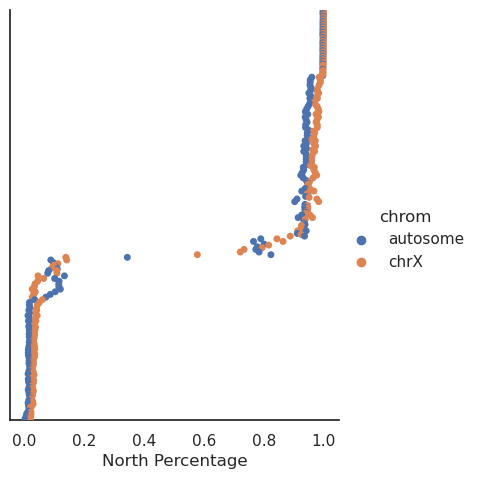

In [21]:
ax = sns.catplot(data=concat_df, x="North Percentage", y="individual", hue="chrom", kind="swarm", legend_out=False)
ax.set(yticks=[], ylabel=None)

In [22]:
concat_df.loc[(concat_df.mean_percent > 0.075) & (concat_df.mean_percent < 0.925)]

,individual,North Percentage,mean_percent,chrom
84,PD_0205,0.911472,0.917785,autosome
85,PD_0651,0.935730,0.911880,autosome
86,PD_0642,0.789783,0.816703,autosome
87,PD_0267,0.765554,0.814715,autosome
88,PD_0265,0.800684,0.808457,autosome
89,PD_0244,0.778003,0.786036,autosome
90,PD_0243,0.773235,0.753756,autosome
91,PD_0641,0.784125,0.752802,autosome
92,PD_0266,0.823577,0.700940,autosome
93,PD_0662,0.345024,0.242577,autosome


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


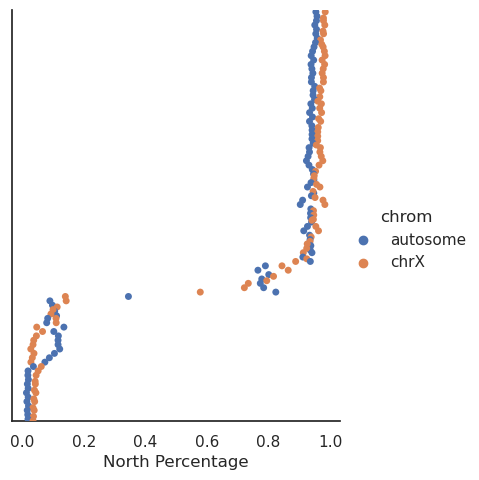

In [23]:
sub_con = concat_df.loc[(concat_df.mean_percent > 0.027) & (concat_df.mean_percent < 0.97)]
ax = sns.catplot(data=sub_con, x="North Percentage", y="individual", hue="chrom", kind="swarm", legend_out=False)
ax.set(yticks=[], ylabel=None)

In [24]:
c_sub = mean_hap_df.loc[mean_hap_df.chrom == "chr10"]
c_sub
#fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

,individual,chrom,start,length,n/s,windows,north
3336,PD_0199,chr10,1330,75843,1.0,1330,1.0
3337,PD_0199,chr10,77173,31603,1.0,77173,1.0
3338,PD_0199,chr10,108776,20439,1.0,108776,1.0
3339,PD_0199,chr10,129215,13905,1.0,129215,1.0
3340,PD_0199,chr10,143120,74491,1.0,143120,1.0
...,...,...,...,...,...,...,...
9437644,Sci_30977,chr10,91150620,9104,1.0,91150620,1.0
9437645,Sci_30977,chr10,91159724,18335,1.0,91159724,1.0
9437646,Sci_30977,chr10,91178059,19476,1.0,91178059,1.0
9437647,Sci_30977,chr10,91197535,90198,1.0,91197535,1.0


In [7]:
mean_hap_df = length_df.groupby(["individual", "chrom", "pos", "length"])[["n/s"]].mean().reset_index()
mean_hap_df = mean_hap_df.rename(columns={"pos": "start"})
mean_hap_df["windows"] = mean_hap_df.start
mean_hap_df["north"] = mean_hap_df["n/s"]

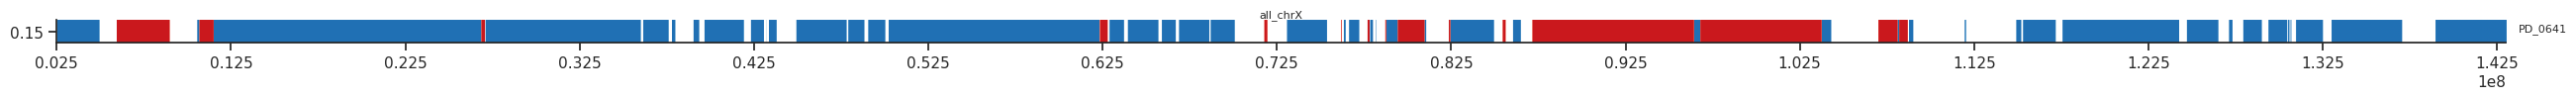

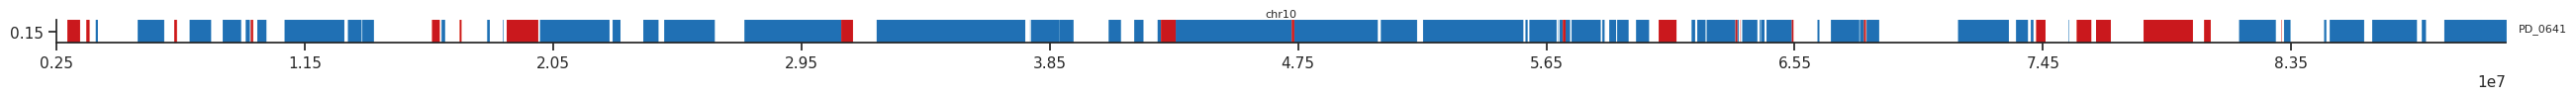

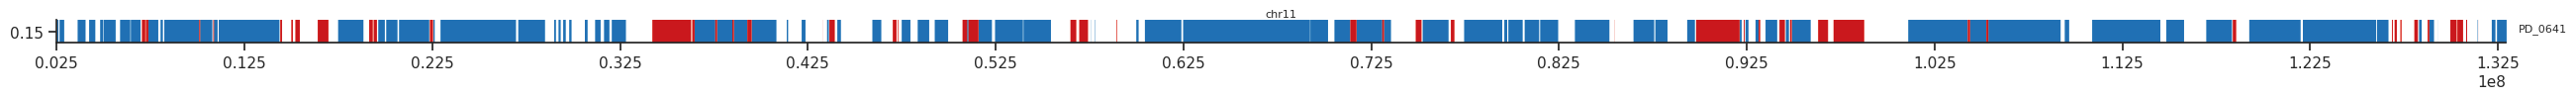

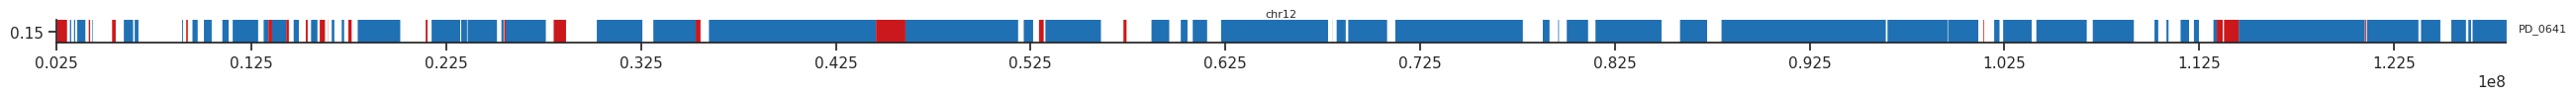

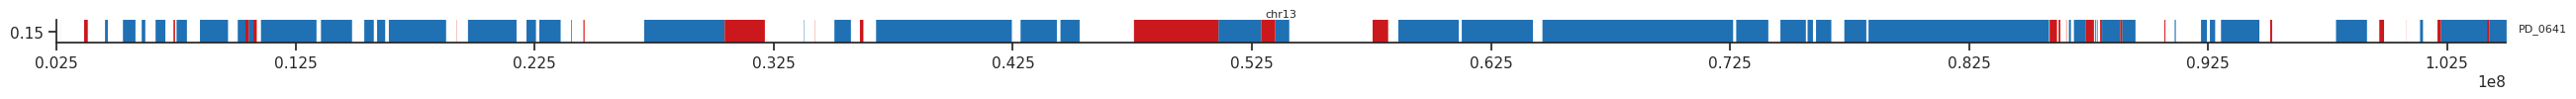

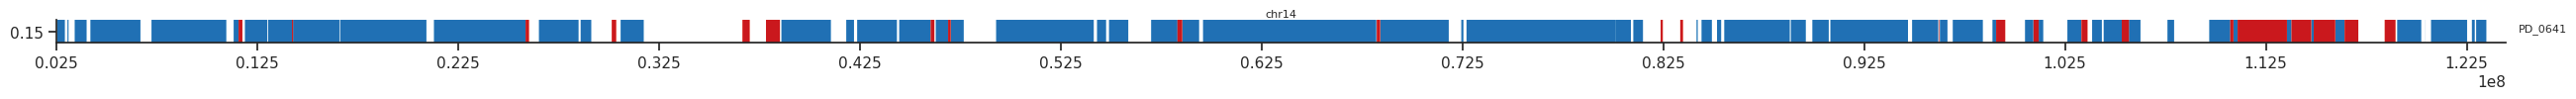

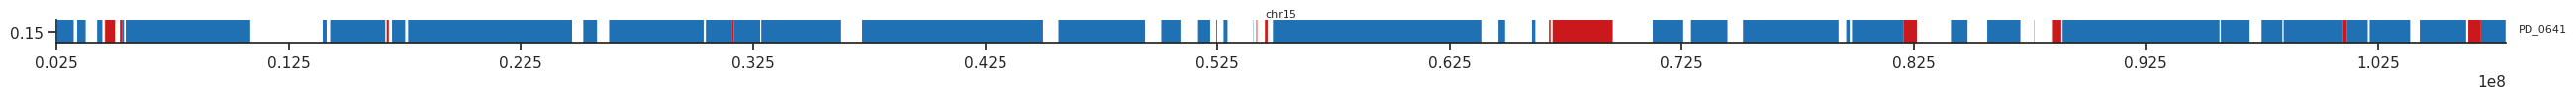

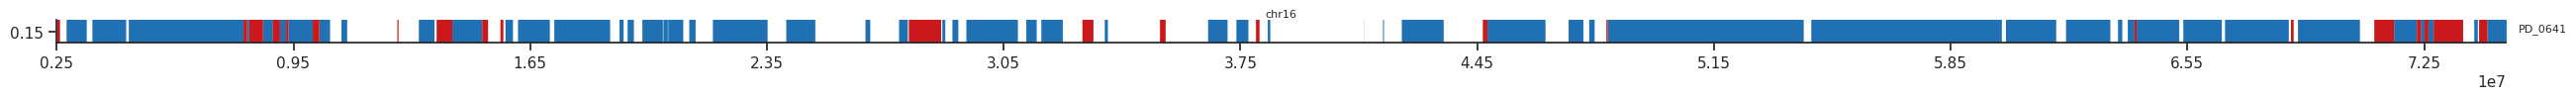

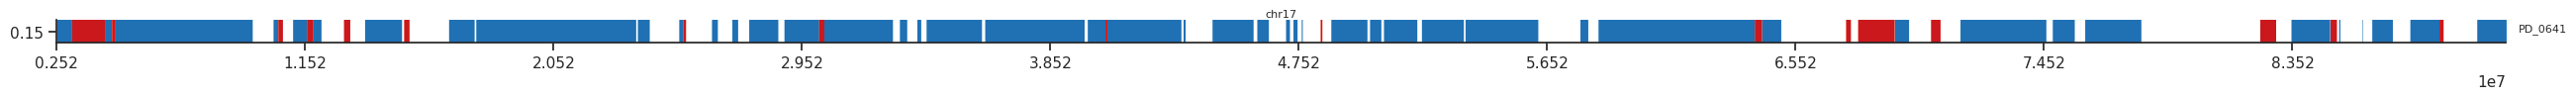

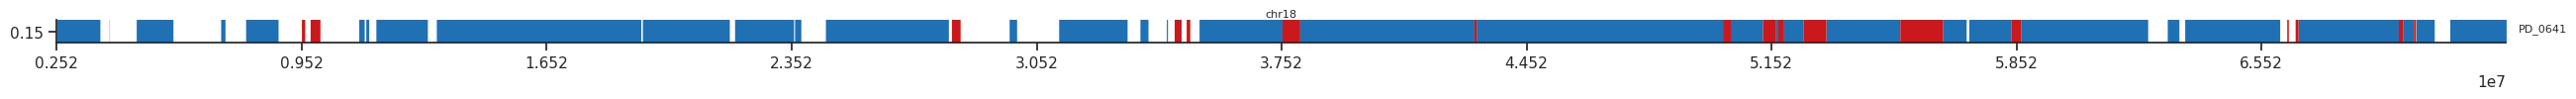

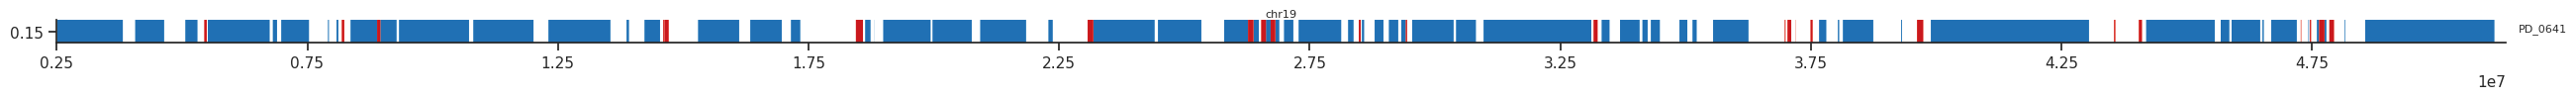

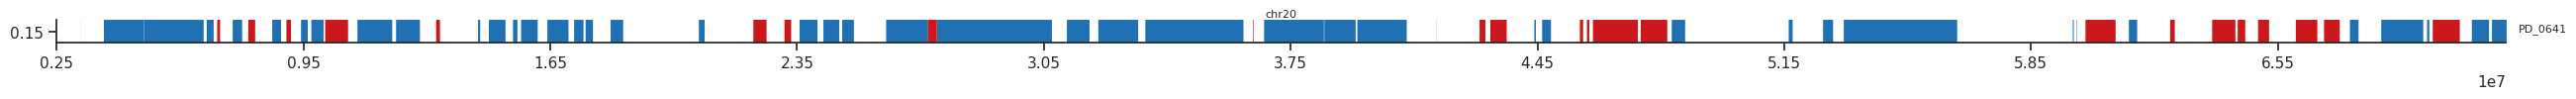

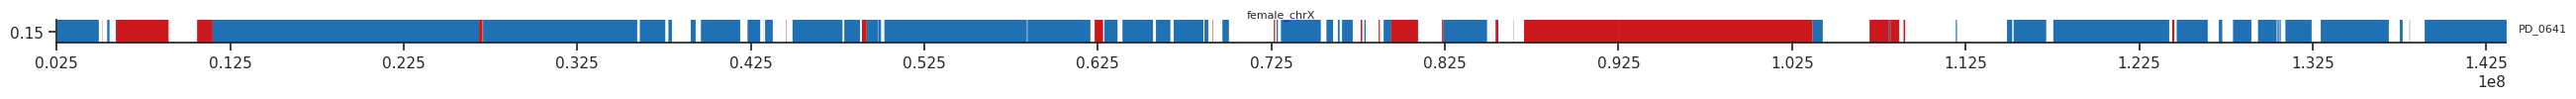

In [8]:
ind_test = mean_hap_df.loc[mean_hap_df.individual == "PD_0641"]
for c in ind_test.chrom.unique():
    c_sub = ind_test.loc[(ind_test.chrom == c) & (ind_test.windows >= 2500000)]
    fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [9]:
x_df = mean_hap_df.loc[mean_hap_df.chrom.isin(["all_chrX"])]
autosomal_df = mean_hap_df.loc[~mean_hap_df.chrom.isin(["all_chrX", "female_chrX"])]

In [10]:
x_df["fragment_weight_x"] = x_df["n/s"]*x_df["length"]

/scratch/22195603/ipykernel_1504096/1567058277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df["fragment_weight_x"] = x_df["n/s"]*x_df["length"]


In [11]:
x_length = x_df.loc[x_df.individual == "PD_0199"].length.sum()

In [12]:
percentage_north_x = ((x_df.groupby(by=["individual"])[["fragment_weight_x"]].sum()+x_length)/(2*x_length))

In [13]:
percentage_north_x.sort_values(by="fragment_weight_x", ascending=False)

,fragment_weight_x
individual,
PD_0733,0.999583
PD_0740,0.999154
PD_0723,0.999154
PD_0737,0.999110
PD_0734,0.999066
...,...
PD_0237,0.023954
PD_0225,0.023946
PD_0235,0.022913


In [14]:
autosomal_df["fragment_weight_aut"] = autosomal_df["n/s"]*autosomal_df["length"]
aut_length = autosomal_df.loc[autosomal_df.individual == "PD_0199"].length.sum()

/scratch/22195603/ipykernel_1504096/4252699820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autosomal_df["fragment_weight_aut"] = autosomal_df["n/s"]*autosomal_df["length"]


In [15]:
percentage_north_aut = ((autosomal_df.groupby(by=["individual"])[["fragment_weight_aut"]].sum()+aut_length)/(2*aut_length))

In [16]:
percentage_north_aut

,fragment_weight_aut
individual,
PD_0199,0.954702
PD_0200,0.953722
PD_0201,0.954621
PD_0202,0.958160
PD_0203,0.957404
...,...
PD_0775,0.014974
Sci_16066,0.018828
Sci_16098,0.017630


In [17]:
x_aut_percent = percentage_north_x.merge(right=percentage_north_aut, on="individual")

In [18]:
x_aut_percent["mean_percent"] = (x_aut_percent.fragment_weight_x+x_aut_percent.fragment_weight_aut)/2
sort_aut_x = x_aut_percent.sort_values(by="mean_percent", ascending=False).reset_index()

In [19]:
aut_sort = sort_aut_x[["individual", "fragment_weight_aut", "mean_percent"]]
aut_sort = aut_sort.rename(columns={"fragment_weight_aut": "North Percentage"})
aut_sort["chrom"] = "autosome"
x_sort = sort_aut_x[["individual", "fragment_weight_x", "mean_percent"]]
x_sort = x_sort.rename(columns={"fragment_weight_x": "North Percentage"})
x_sort["chrom"] = "chrX"
concat_df = pd.concat([aut_sort, x_sort])

In [20]:
concat_df

,individual,North Percentage,mean_percent,chrom
0,PD_0740,0.997247,0.998201,autosome
1,PD_0733,0.996806,0.998194,autosome
2,PD_0731,0.997699,0.998174,autosome
3,PD_0743,0.997376,0.998090,autosome
4,PD_0736,0.997087,0.998077,autosome
...,...,...,...,...
150,PD_0766,0.022301,0.020097,chrX
151,PD_0225,0.023946,0.019419,chrX
152,PD_0237,0.023954,0.016708,chrX
153,PD_0236,0.022163,0.014893,chrX


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


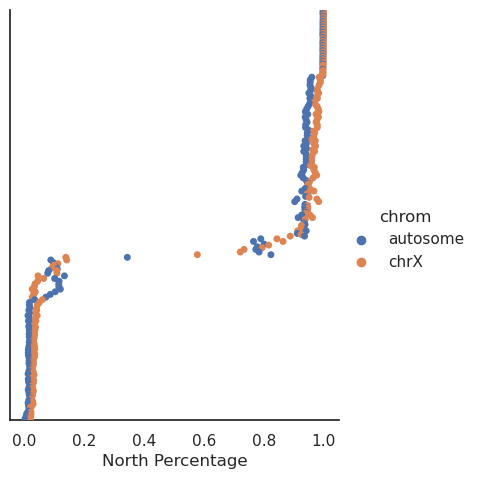

In [21]:
ax = sns.catplot(data=concat_df, x="North Percentage", y="individual", hue="chrom", kind="swarm", legend_out=False)
ax.set(yticks=[], ylabel=None)

In [22]:
concat_df.loc[(concat_df.mean_percent > 0.075) & (concat_df.mean_percent < 0.925)]

,individual,North Percentage,mean_percent,chrom
84,PD_0205,0.911472,0.917785,autosome
85,PD_0651,0.935730,0.911880,autosome
86,PD_0642,0.789783,0.816703,autosome
87,PD_0267,0.765554,0.814715,autosome
88,PD_0265,0.800684,0.808457,autosome
89,PD_0244,0.778003,0.786036,autosome
90,PD_0243,0.773235,0.753756,autosome
91,PD_0641,0.784125,0.752802,autosome
92,PD_0266,0.823577,0.700940,autosome
93,PD_0662,0.345024,0.242577,autosome


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


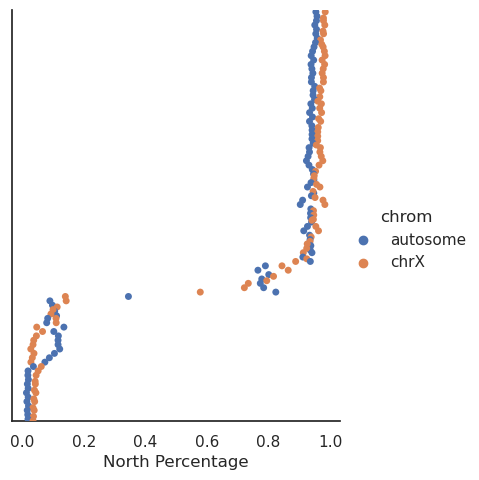

In [23]:
sub_con = concat_df.loc[(concat_df.mean_percent > 0.027) & (concat_df.mean_percent < 0.97)]
ax = sns.catplot(data=sub_con, x="North Percentage", y="individual", hue="chrom", kind="swarm", legend_out=False)
ax.set(yticks=[], ylabel=None)

In [24]:
c_sub = mean_hap_df.loc[mean_hap_df.chrom == "chr10"]
c_sub
#fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

,individual,chrom,start,length,n/s,windows,north
3336,PD_0199,chr10,1330,75843,1.0,1330,1.0
3337,PD_0199,chr10,77173,31603,1.0,77173,1.0
3338,PD_0199,chr10,108776,20439,1.0,108776,1.0
3339,PD_0199,chr10,129215,13905,1.0,129215,1.0
3340,PD_0199,chr10,143120,74491,1.0,143120,1.0
...,...,...,...,...,...,...,...
9437644,Sci_30977,chr10,91150620,9104,1.0,91150620,1.0
9437645,Sci_30977,chr10,91159724,18335,1.0,91159724,1.0
9437646,Sci_30977,chr10,91178059,19476,1.0,91178059,1.0
9437647,Sci_30977,chr10,91197535,90198,1.0,91197535,1.0


In [25]:
df_l = []
for ID in concat_df.individual:
    df_l.append(c_sub.loc[c_sub.individual == ID])
sorted_df = pd.concat(df_l)
sorted_df = sorted_df.reset_index()

In [26]:
list(concat_df.individual)

['PD_0740',
 'PD_0733',
 'PD_0731',
 'PD_0743',
 'PD_0736',
 'PD_0737',
 'PD_0742',
 'PD_0734',
 'PD_0728',
 'PD_0723',
 'PD_0738',
 'PD_0722',
 'PD_0735',
 'PD_0727',
 'PD_0730',
 'PD_0744',
 'PD_0724',
 'PD_0729',
 'PD_0726',
 'PD_0741',
 'PD_0732',
 'PD_0720',
 'PD_0721',
 'PD_0739',
 'PD_0725',
 'PD_0496',
 'PD_0199',
 'PD_0201',
 'PD_0200',
 'PD_0203',
 'PD_0495',
 'PD_0497',
 'PD_0494',
 'PD_0500',
 'PD_0202',
 'PD_0493',
 'PD_0501',
 'PD_0674',
 'PD_0492',
 'PD_0680',
 'PD_0649',
 'PD_0208',
 'PD_0209',
 'PD_0653',
 'PD_0240',
 'PD_0498',
 'PD_0681',
 'PD_0675',
 'PD_0499',
 'PD_0505',
 'PD_0683',
 'PD_0502',
 'PD_0241',
 'PD_0685',
 'PD_0677',
 'PD_0676',
 'PD_0239',
 'PD_0678',
 'PD_0682',
 'PD_0654',
 'PD_0508',
 'PD_0211',
 'PD_0210',
 'PD_0242',
 'PD_0220',
 'PD_0218',
 'PD_0222',
 'PD_0221',
 'PD_0212',
 'PD_0219',
 'PD_0507',
 'PD_0207',
 'PD_0204',
 'PD_0509',
 'PD_0686',
 'PD_0679',
 'PD_0238',
 'PD_0684',
 'Sci_30877',
 'PD_0506',
 'PD_0652',
 'PD_0206',
 'PD_0504',
 '

In [27]:
i_df = sorted_df.loc[sorted_df.individual.isin(["PD_0641", "PD_0651", "PD_0213"])]

Cant sort horizonplot, as fas as I can see

In [ ]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

In [ ]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(10, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)